In [1]:
# import sys
import os

# SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
# sys.path.append(os.path.dirname(SCRIPT_DIR))

from pymongo import MongoClient
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pickle
from color_calculator import outfit_comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from conversions import hex_to_rgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# function to flatten color array
def flatten_array(arr, name):
    '''Takes in a color array and returns its expansion as a pandas series'''
    arr = np.array(arr) # will need list as numpy array for flattening
    # build array of column names so that the expansion will go like item_color1, item_weight1, item_color2, ..., etc
    column_names = [f'{name}_{base}{i}' for i in range(1, 5) for base in ['color', 'weight']]
    return pd.Series(arr.flatten(), index=column_names)

def complementariness(item1, item2):
    return outfit_comparison(item1, item2)[0]

def similarity(item1, item2):
    return outfit_comparison(item1, item2)[1]

def neutrality(item1, item2):
    return outfit_comparison(item1, item2)[2]

In [3]:
# Initialize ENV
load_dotenv()

# Source ENV
connectionString = os.getenv('DB_CONNECTION_PY')
# Connect to Mongo
client = MongoClient(connectionString)
# Connect to DB
db = client['archive']
print('Connected to database')

# connect to set of mens reacted outfits
cursor = db['reacted_sets'].find({'sex': "M"})
# convert mongo cursor into dataframe
outfits_men = pd.DataFrame(list(cursor))

# connect to set of mens reacted outfits
cursor = db['reacted_sets'].find({'sex': "F"})
# convert mongo cursor into dataframe
outfits_women = pd.DataFrame(list(cursor))

# drop currently irrelevant columns
outfits_men = outfits_men[['top_id', 'bottom_id', 'shoe_id', 'reaction']]
outfits_women = outfits_women[['top_id', 'bottom_id', 'shoe_id', 'reaction']]

# pull archival tables of items into dataframes
#* tops
cursor = db['tops'].find(projection=['productColors']) # only project relevant column
tops = pd.DataFrame(list(cursor))
# rename _id column for merging, colors column for distinctness
tops = tops.rename(columns={'_id': 'top_id', 'productColors': 'top_colors'})
# expand color array into 8 columns
expanded = tops['top_colors'].apply(flatten_array, name='top') # get flattened series
# add new columns to dataframe
tops = pd.concat([tops, expanded], axis=1)

#* bottoms
cursor = db['bottoms'].find(projection=['productColors'])
bottoms = pd.DataFrame(list(cursor))
bottoms = bottoms.rename(columns={'_id': 'bottom_id', 'productColors': 'bottom_colors'})
expanded = bottoms['bottom_colors'].apply(flatten_array, name='bottom')
bottoms = pd.concat([bottoms, expanded], axis=1)

#* shoes
cursor = db['shoes'].find(projection=['productColors'])
shoes = pd.DataFrame(list(cursor))
shoes = shoes.rename(columns={'_id': 'shoe_id', 'productColors': 'shoe_colors'})
expanded = shoes['shoe_colors'].apply(flatten_array, name='shoe')
shoes = pd.concat([shoes, expanded], axis=1)

# close client
client.close()
print('Client closed.')

Connected to database
Client closed.


In [5]:
# inner join item tables into the outfits_men dataframe
outfits_men = outfits_men.merge(tops, on='top_id')
outfits_men = outfits_men.merge(bottoms, on='bottom_id')
outfits_men = outfits_men.merge(shoes, on='shoe_id')

# inner join item tables into the outfits_men dataframe
outfits_women = outfits_women.merge(tops, on='top_id')
outfits_women = outfits_women.merge(bottoms, on='bottom_id')
outfits_women = outfits_women.merge(shoes, on='shoe_id')

# modify column data types
float_cols = ['reaction', 'top_weight1', 'top_weight2', 'top_weight3', 'top_weight4', \
            'bottom_weight1', 'bottom_weight2', 'bottom_weight3', 'bottom_weight4', \
            'shoe_weight1', 'shoe_weight2', 'shoe_weight3', 'shoe_weight4']
outfits_men[float_cols] = outfits_men[float_cols].astype(float)
outfits_women[float_cols] = outfits_women[float_cols].astype(float)

str_cols = ['top_color1', 'top_color2', 'top_color3', 'top_color4', \
            'bottom_color1', 'bottom_color2', 'bottom_color3', 'bottom_color4', \
            'shoe_color1', 'shoe_color2', 'shoe_color3', 'shoe_color4']
outfits_men[str_cols] = outfits_men[str_cols].astype('string')
outfits_women[str_cols] = outfits_women[str_cols].astype('string')

outfits_men = outfits_men[['reaction', 'top_colors', 'bottom_colors', 'shoe_colors']]
outfits_women = outfits_women[['reaction', 'top_colors', 'bottom_colors', 'shoe_colors']]

In [6]:
# comparisons for top and bottom
outfits_men['TB_complementary'] = outfits_men.apply(lambda row: complementariness(row['top_colors'], row['bottom_colors']), axis=1)
outfits_men['TB_similarity'] = outfits_men.apply(lambda row: similarity(row['top_colors'], row['bottom_colors']), axis=1)
outfits_men['TB_neutrality'] = outfits_men.apply(lambda row: neutrality(row['top_colors'], row['bottom_colors']), axis=1)

outfits_women['TB_complementary'] = outfits_women.apply(lambda row: complementariness(row['top_colors'], row['bottom_colors']), axis=1)
outfits_women['TB_similarity'] = outfits_women.apply(lambda row: similarity(row['top_colors'], row['bottom_colors']), axis=1)
outfits_women['TB_neutrality'] = outfits_women.apply(lambda row: neutrality(row['top_colors'], row['bottom_colors']), axis=1)

# comparisons for top and shoe
outfits_men['TS_complementary'] = outfits_men.apply(lambda row: complementariness(row['top_colors'], row['shoe_colors']), axis=1)
outfits_men['TS_similarity'] = outfits_men.apply(lambda row: similarity(row['top_colors'], row['shoe_colors']), axis=1)
outfits_men['TS_neutrality'] = outfits_men.apply(lambda row: neutrality(row['top_colors'], row['shoe_colors']), axis=1)

outfits_women['TS_complementary'] = outfits_women.apply(lambda row: complementariness(row['top_colors'], row['shoe_colors']), axis=1)
outfits_women['TS_similarity'] = outfits_women.apply(lambda row: similarity(row['top_colors'], row['shoe_colors']), axis=1)
outfits_women['TS_neutrality'] = outfits_women.apply(lambda row: neutrality(row['top_colors'], row['shoe_colors']), axis=1)

# comparisons for bottom and shoe
outfits_men['BS_complementary'] = outfits_men.apply(lambda row: complementariness(row['bottom_colors'], row['shoe_colors']), axis=1)
outfits_men['BS_similarity'] = outfits_men.apply(lambda row: similarity(row['bottom_colors'], row['shoe_colors']), axis=1)
outfits_men['BS_neutrality'] = outfits_men.apply(lambda row: neutrality(row['bottom_colors'], row['shoe_colors']), axis=1)

outfits_women['BS_complementary'] = outfits_women.apply(lambda row: complementariness(row['bottom_colors'], row['shoe_colors']), axis=1)
outfits_women['BS_similarity'] = outfits_women.apply(lambda row: similarity(row['bottom_colors'], row['shoe_colors']), axis=1)
outfits_women['BS_neutrality'] = outfits_women.apply(lambda row: neutrality(row['bottom_colors'], row['shoe_colors']), axis=1)

# variables for fitting to the model
X_men = outfits_men[['TB_complementary', 'TB_similarity', 'TB_neutrality', \
    'TS_complementary', 'TS_similarity', 'TS_neutrality', \
    'BS_complementary', 'BS_similarity', 'BS_neutrality']]
y_men = outfits_men['reaction']

# variables for fitting to the model
X_women = outfits_women[['TB_complementary', 'TB_similarity', 'TB_neutrality', \
    'TS_complementary', 'TS_similarity', 'TS_neutrality', \
    'BS_complementary', 'BS_similarity', 'BS_neutrality']]
y_women = outfits_women['reaction']

In [44]:
# split entry data
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X_men, y_men)

X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_women, y_women)

In [16]:

#* ======= MODEL 1 ======= RANDOM FOREST =======
# grid search for finding parameters
# params = {'n_estimators': range(50, 501, 50), 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': range(2,21)}
params = {'n_estimators': range(100, 501, 50), 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', None], 'min_samples_split': range(2, 20, 4)}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, params, n_jobs=-1, verbose=1)
# clf.fit(X_train_M, y_train_M)
clf.fit(X_train_F, y_train_F)
print(clf.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'criterion': 'gini', 'max_features': None, 'min_samples_split': 14, 'n_estimators': 450}


In [27]:

#* men's model
men_model = RandomForestClassifier(450, criterion='entropy', max_features='sqrt', min_samples_split=18)
men_model.fit(X_train_M.values, y_train_M.values)

#* women's model
women_model = RandomForestClassifier(450, criterion='gini', max_features=None, min_samples_split=14)
women_model.fit(X_train_F.values, y_train_F.values)

RandomForestClassifier(max_features=None, min_samples_split=14,
                       n_estimators=450)

In [30]:
# test accuracy
preds = men_model.predict(X_test_M.values)
print("Men's random forest accuracy:", accuracy_score(y_test_M, preds))

# current best: 0.86

preds = women_model.predict(X_test_F.values)
print("Women's random forest accuracy:", accuracy_score(y_test_F, preds))

# current best: 0.93

Men's random forest accuracy: 0.859375
Women's random forest accuracy: 0.9310344827586207


In [44]:
# view feature importance
print("MENS:")
for i in range(len(list(X_men.columns))):
    print(f'{list(X_men.columns)[i]:<20}{men_model.feature_importances_[i]:>20}')

print("WOMENS:")
for i in range(len(list(X_women.columns))):
    print(f'{list(X_women.columns)[i]:<20}{women_model.feature_importances_[i]:>20}')

MENS:
TB_complementary      0.1425177165346686
TB_similarity        0.08558429148054912
TB_neutrality        0.07678596801177565
TS_complementary     0.15282449436731008
TS_similarity        0.07581087527261342
TS_neutrality        0.09090930241128209
BS_complementary     0.09814919813001181
BS_similarity        0.10968547020950277
BS_neutrality         0.1677326835822865
WOMENS:
TB_complementary     0.13461416527580422
TB_similarity         0.1939024377655437
TB_neutrality        0.11383941956728266
TS_complementary      0.1032353708721407
TS_similarity        0.09320519224155606
TS_neutrality         0.1059241545582374
BS_complementary     0.09022500520823815
BS_similarity        0.06156615403505049
BS_neutrality        0.10348810047614672


In [33]:
# save men's model to file
with open('random_forest_men.txt', 'wb') as file:
    pickle.dump(men_model, file)

In [31]:
# save women's model to file
with open('random_forest_women.txt', 'wb') as file:
    pickle.dump(women_model, file)

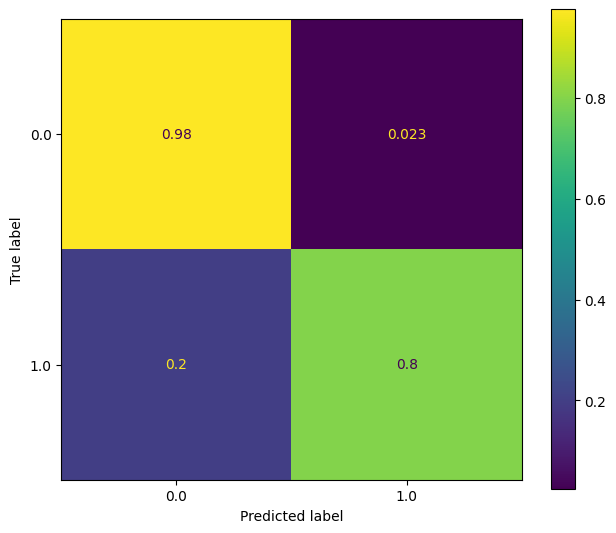

In [32]:
cm = confusion_matrix(y_test_F, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=women_model.classes_)
disp.plot()
plt.subplots_adjust(0.1,0,1,1)
plt.show()

In [46]:

#* ======= MODEL 2 ======= REGRESSOR =======
# men's model
# men_regress = RandomForestRegressor(criterion='poisson', max_features='sqrt', min_samples_split=2, n_estimators=400)
# men_regress.fit(X_train_M.values, y_train_M.values)

men_regress = LogisticRegression(solver='liblinear', penalty='l1')
men_regress.fit(X_train_M.values, y_train_M.values)

# women's model
# women_regress = RandomForestRegressor(criterion='squared_error', max_features='sqrt', min_samples_split=19, n_estimators=50)
# women_regress.fit(X_train_F.values, y_train_F.values)

women_regress = LogisticRegression(solver='liblinear', penalty='l1')
women_regress.fit(X_train_F.values, y_train_F.values)

LogisticRegression(penalty='l1', solver='liblinear')

In [35]:
# grid search for finding parameters
params = {'penalty': ['l1', 'l2']}
lr = LogisticRegression(solver='liblinear')
clf = GridSearchCV(lr, params, n_jobs=-1, verbose=1)
clf.fit(X_train_M, y_train_M)
print(clf.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'penalty': 'l1'}


In [47]:

#* men's testing
# check r^2 value for the fit
preds = men_regress.predict(X_test_M.values)
print("Men's R2 value: ", r2_score(y_test_M, preds))

# best: -0.3

# test accuracy by rounding to like or dislike
midp = max(preds) / 2
print('Regression midpoint:', midp)
for i in range(len(preds)):
    if preds[i] >= midp:
        preds[i] = 1
    else:
        preds[i] = 0

print("Men's regression accuracy:", accuracy_score(y_test_M, preds))

# best: 0.68

#* women's testing
# check r^2 value for the fit
preds = men_model.predict(X_test_F.values)
print("Women's R2 value: ", r2_score(y_test_F, preds))

# best: -2.56

# test accuracy by rounding to like or dislike
midp = max(preds) / 2
print('Regression midpoint:', midp)
for i in range(len(preds)):
    if preds[i] <= midp:
        preds[i] = 1
    else:
        preds[i] = 0

print("Women's regression accuracy:", accuracy_score(y_test_F, preds))

# best: 0.69

Men's R2 value:  -0.9903275176002448
Regression midpoint: 0.5
Men's regression accuracy: 0.50390625
Women's R2 value:  -1.7760683760683755
Regression midpoint: 0.5
Women's regression accuracy: 0.4827586206896552


In [69]:
# save trained men's model to pickle file
with open('regression_men.txt', 'wb') as file:
    pickle.dump(men_regress, file)

In [70]:
# save trained men's model to pickle file
with open('regression_women.txt', 'wb') as file:
    pickle.dump(women_regress, file)